<a href="https://colab.research.google.com/github/jaeseongrhythm/circadian-predict-AI/blob/main/%EC%9D%BC%EC%A3%BC%EA%B8%B0_%EC%83%9D%EC%B2%B4%EB%A6%AC%EB%93%AC_%EC%98%88%EC%B8%A1_AI_v0_19_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- 'train' 모드 시작: 전체 파이프라인을 실행합니다. ---
--- 데이터 로딩 시작: biometric_data_person_1/biometric_data_person_1.csv ---
--- 데이터 로딩 및 기본 전처리 완료 ---
--- 데이터 처리 시작 ---
--- [1단계] 일일 재조정 기준 궤도 생성 시작 ---
안정 궤도를 새로 계산합니다 (최초 1회 실행)...
새로운 안정 궤도를 저장했습니다: final_biometric_pipeline_output_v0.20_LCO_Viz/stable_limit_cycle.npy


일일 기준 궤도 생성 중: 100%|██████████| 20/20 [00:04<00:00,  4.75it/s]


--- [1단계] 일일 재조정 기준 궤도 생성 완료 ---
--- 데이터 처리 완료 ---

--- 데이터 분할 및 스케일링 시작 ---
스케일러 학습 및 저장 완료.
--- 모든 잠재적 생체 마커 사전 계산 시작 ---
--- 모든 잠재적 생체 마커 사전 계산 완료 ---
--- TFRecord 파일 생성 시작: final_biometric_pipeline_output_v0.20_LCO_Viz/train.tfrecord ---


train.tfrecord 생성 중: 100%|██████████| 14928/14928 [02:12<00:00, 112.52it/s]


--- TFRecord 파일 생성 완료: final_biometric_pipeline_output_v0.20_LCO_Viz/train.tfrecord ---
--- TFRecord 파일 생성 시작: final_biometric_pipeline_output_v0.20_LCO_Viz/val.tfrecord ---


val.tfrecord 생성 중: 100%|██████████| 1866/1866 [00:16<00:00, 114.40it/s]


--- TFRecord 파일 생성 완료: final_biometric_pipeline_output_v0.20_LCO_Viz/val.tfrecord ---

--- 최종 모델 학습 및 검증 시작 ---

Epoch 1/3


1866/1866 ━━━━━━━━━━━━━━━━━━━━ 1926s 1s/step - train_loss: 1.6908



Validation Loss (scaled): 0.3315
Validation loss improved. Saving model weights to final_biometric_pipeline_output_v0.20_LCO_Viz/best_model.weights.h5
Generating LCO trajectory visualization for this epoch...


Visualization saved.

Epoch 2/3
1866/1866 ━━━━━━━━━━━━━━━━━━━━ 1899s 1s/step - train_loss: 1.8245

Validation Loss (scaled): 0.2369
Validation loss improved. Saving model weights to final_biometric_pipeline_output_v0.20_LCO_Viz/best_model.weights.h5
Generating LCO trajectory visualization for this epoch...


Visualization saved.

Epoch 3/3
1866/1866 ━━━━━━━━━━━━━━━━━━━━ 1900s 1s/step - train_loss: 2.3573

Validation Loss (scaled): 0.2132
Validation loss improved. Saving model weights to final_biometric_pipeline_output_v0.20_LCO_Viz/best_model.weights.h5
Generating LCO trajectory visualization for this epoch...


Visualization saved.

--- 학습 및 검증 완료 ---
학습 곡선 그래프가 final_biometric_pipeline_output_v0.20_LCO_Viz/learning_curve.png에 저장되었습니다.

--- 'predict' 모드 시작: 저장된 모델로 예측을 수행합니다. ---


모델 가중치 로드 완료.

--- 미래 심박수 예측 시작 ---
--- 모든 잠재적 생체 마커 사전 계산 시작 ---
--- 모든 잠재적 생체 마커 사전 계산 완료 ---


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
--- 예측 완료 ---


NameError: name 'output_dir' is not defined

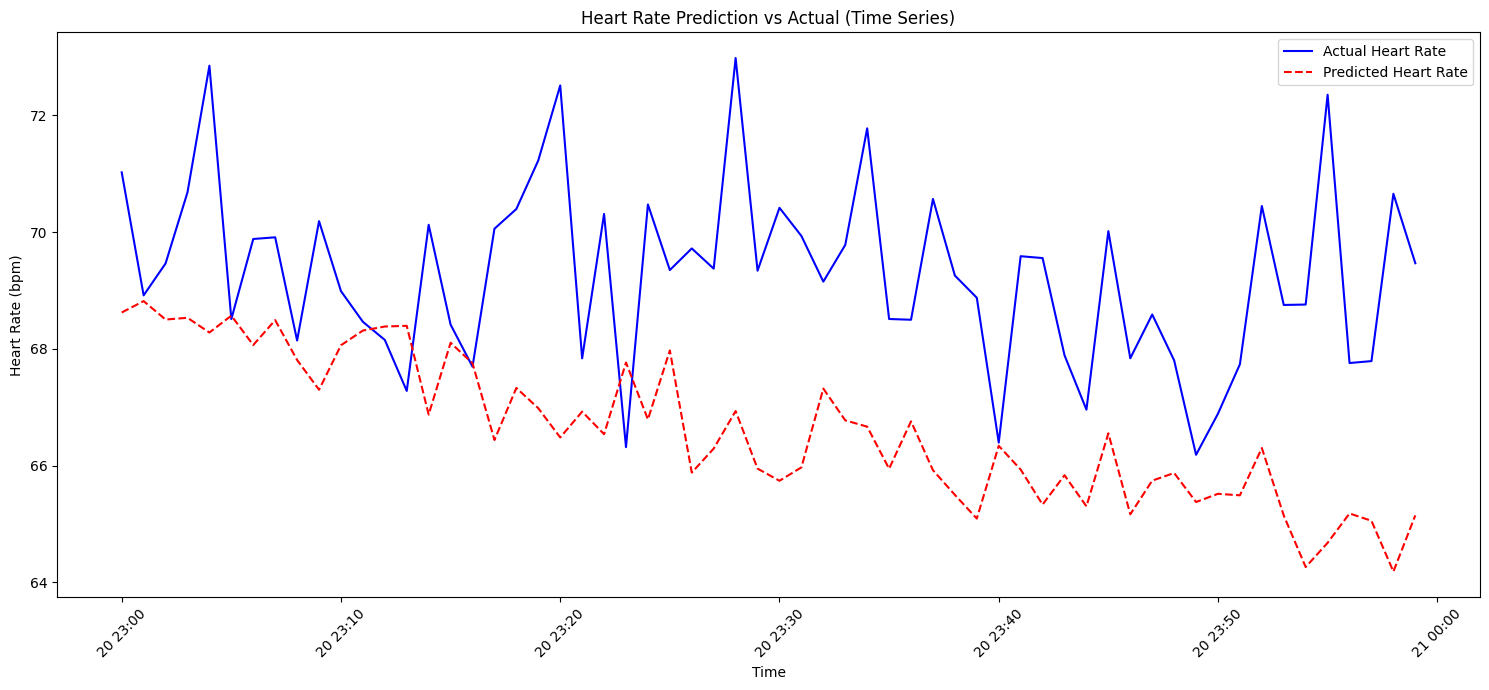

In [1]:
# -*- coding: utf-8 -*-
"""
일주기 생체리듬 예측 AI v0.19 (LCO 궤적 시각화 통합)

[v0.19.0 변경 사항]:
- 데이터 생성기 분리: 더 무작위적이고 생리학적인 데이터 생성
- 훈련 중 시각화 로직 변경: 기존의 입력 데이터 리포트 생성을 제거.
- LCO 궤적 시각화 기능 추가: 매 에포크 종료 시, 검증 데이터 샘플에 대한 모델의 예측 결과를 시각화하는 `plot_lco_comparison` 함수를 추가.
- 시각화 내용:
  - 시간에 따른 LCO 상태 변수(x, xc)의 변화 (기준 궤적 vs 모델 보정 궤적).
  - 일별 LCO 상태 평면 사이클(Phase-space plot).
- 모델 수정: `IntegratedModel`에 `return_trajectory` 플래그를 추가하여, 예측 시 LCO 궤적을 함께 반환할 수 있도록 수정.
- 파이프라인 통합: `train_and_evaluate` 함수 내에서 에포크마다 시각화 함수를 호출하여 학습 과정을 추적.
"""

# =============================================================================
# 0. 라이브러리 임포트 및 파이프라인 설정
# =============================================================================
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Concatenate, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
import os
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
import joblib
from tqdm import tqdm
import argparse
import random
import math
import bisect

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# [OPTIMIZATION] 혼합 정밀도 정책 설정. GPU 학습 시 속도 및 메모리 효율 향상.
mixed_precision.set_global_policy('mixed_float16')

# --- 파이프라인 제어 설정 ---
OUTPUT_DIR = "final_biometric_pipeline_output_v0.19_LCO_Viz"

# --- 데이터 및 모델 설정 (PC 환경 최적화) ---
INPUT_SEQUENCE_LENGTH = 4 * 24 * 60
PREDICTION_HORIZON = 60
PHASE_CORRECTION_LOOKBACK_DAYS = 3
DAY_MINUTES = 24 * 60
NUM_MARKERS_TO_KEEP = 3

TRAIN_RATIO = 0.8
VALIDATION_RATIO = 0.1

# --- 모델 하이퍼파라미터 (성능 튜닝) ---
D_MODEL = 128
NUM_LAYERS = 2
NUM_HEADS = 8
DFF = 256
DROPOUT_RATE = 0.05
NUM_FOURIER_HARMONICS = 5
LSTM_UNITS = 64

# --- 학습 하이퍼파라미터 (성능 튜닝) ---
EPOCHS = 3
BATCH_SIZE = 8
LEARNING_RATE = 0.0005
LAMBDA_REG = 0.1
LAMBDA_CONT = 10.0
LAMBDA_ANCHOR = 5.0

# --- 하이퍼파라미터 검증 ---
assert D_MODEL % NUM_HEADS == 0, f"D_MODEL({D_MODEL})은 NUM_HEADS({NUM_HEADS})로 나누어떨어져야 합니다."

# --- 물리 모델 파라미터 (St. Hilaire et al., 2007 기반) ---
PARAMS = {
    'mu': 0.13, 'q': 1/3, 'k': 0.55, 'alpha0': 0.1, 'I0': 9500,
    'p': 0.5, 'beta': 0.007, 'G': 37, 'rho': 0.032, 'tau_x': 24.2,
}

# =============================================================================
# 1. 생체리듬 물리 모델 (SCN 코어 엔진) 및 헬퍼 함수
# =============================================================================
def find_hr_nadir(heart_rate_data, is_sleeping_data, day_minutes=1440):
    num_days = len(heart_rate_data) // day_minutes
    daily_nadirs = []
    for day in range(num_days):
        day_start, day_end = day * day_minutes, (day + 1) * day_minutes
        day_hr, day_sleep = heart_rate_data[day_start:day_end], is_sleeping_data[day_start:day_end]
        sleep_hr = day_hr[day_sleep == 1]
        if len(sleep_hr) > 0:
            original_indices = np.where(day_sleep == 1)[0]
            daily_nadirs.append(original_indices[np.argmin(sleep_hr)])
        else:
            daily_nadirs.append(np.argmin(day_hr))
    return np.mean(daily_nadirs) if daily_nadirs else day_minutes / 2

def _sigmoid(x, k=2, x0=0):
    return 1 / (1 + np.exp(-k * (x - x0)))

def lco_model_ode(t, y, params, light_func, sleep_func):
    x, xc, n = y
    if not np.all(np.isfinite(y)): return [0,0,0]

    mu, q, k, alpha0, I0, p, beta, G, rho, tau_x = params.values()
    I, sigma = light_func(t), sleep_func(t)
    I = max(I, 0)
    alpha = alpha0 * ((I / I0)**p) * (I / (I + 100.0)) if I > 0 else 0
    B_hat = G * (1 - n) * alpha
    B = B_hat * (1 - 0.4 * x) * (1 - 0.4 * xc)

    cbt_min_phase_angle = -170.7 * np.pi / 180.0
    current_phase = np.arctan2(xc, x)
    phase_diff_rad = (current_phase - cbt_min_phase_angle + np.pi) % (2 * np.pi) - np.pi
    psi_c_x = phase_diff_rad * (tau_x / (2 * np.pi)) + (tau_x / 2)
    weight_enter = _sigmoid(psi_c_x, k=2, x0=16.5)
    weight_exit = 1 - _sigmoid(psi_c_x, k=2, x0=21.0)
    wmz_weight = weight_enter * weight_exit * sigma
    Ns_hat_normal = rho * (1/3.0 - sigma)
    Ns_hat_wmz = rho * (1/3.0)
    Ns_hat = Ns_hat_normal * (1 - wmz_weight) + Ns_hat_wmz * wmz_weight
    Ns = Ns_hat * (1 - np.tanh(10 * x))

    dxdt = (np.pi / 12.0) * (xc + mu * (x/3.0 + (4.0/3.0)*x**3 - (256.0/105.0)*x**7) + B + Ns)
    tau_term_sq = (24.0 / (0.99729 * tau_x))**2
    dxc_dt = (np.pi / 12.0) * (q * B * xc - x * (tau_term_sq + k * B))
    dn_dt = 60.0 * (alpha * (1 - n) - beta * n)
    return [dxdt, dxc_dt, dn_dt]

def lco_model_jacobian(t, y, params, light_func, sleep_func):
    x, xc, n = y
    if not np.all(np.isfinite(y)): return np.zeros((3,3))

    mu, q, k, alpha0, I0, p, beta, G, rho, tau_x = params.values()
    I, sigma = light_func(t), sleep_func(t)
    I = max(I, 0)
    alpha = alpha0 * ((I / I0)**p) * (I / (I + 100.0)) if I > 0 else 0
    cbt_min_phase_angle = -170.7 * np.pi / 180.0
    current_phase = np.arctan2(xc, x)
    phase_diff_rad = (current_phase - cbt_min_phase_angle + np.pi) % (2 * np.pi) - np.pi
    psi_c_x = phase_diff_rad * (tau_x / (2 * np.pi)) + (tau_x / 2)
    weight_enter = _sigmoid(psi_c_x, k=2, x0=16.5)
    weight_exit = 1 - _sigmoid(psi_c_x, k=2, x0=21.0)
    wmz_weight = weight_enter * weight_exit * sigma
    Ns_hat_normal = rho * (1/3.0 - sigma)
    Ns_hat_wmz = rho * (1/3.0)
    Ns_hat = Ns_hat_normal * (1 - wmz_weight) + Ns_hat_wmz * wmz_weight
    dB_dx = -0.4 * G * alpha * (1 - n) * (1 - 0.4 * xc)
    dB_dxc = -0.4 * G * alpha * (1 - n) * (1 - 0.4 * x)
    dB_dn = -G * alpha * (1 - 0.4 * x) * (1 - 0.4 * xc)
    dNs_dx = -Ns_hat * 10.0 * (1.0 / np.cosh(10 * x))**2
    J = np.zeros((3, 3))
    J[0, 0] = (np.pi / 12.0) * (mu * (1/3.0 + 4.0 * x**2 - (256.0*7.0/105.0) * x**6) + dB_dx + dNs_dx)
    J[0, 1] = (np.pi / 12.0) * (1.0 + dB_dxc)
    J[0, 2] = (np.pi / 12.0) * dB_dn
    B = G * alpha * (1 - n) * (1 - 0.4 * x) * (1 - 0.4 * xc)
    tau_term_sq = (24.0 / (0.99729 * tau_x))**2
    J[1, 0] = (np.pi / 12.0) * (q * xc * dB_dx - (tau_term_sq + k * B) - k * x * dB_dx)
    J[1, 1] = (np.pi / 12.0) * (q * B + q * xc * dB_dxc - k * x * dB_dxc)
    J[1, 2] = (np.pi / 12.0) * (q * xc * dB_dn - k * x * dB_dn)
    J[2, 2] = 60.0 * (-alpha - beta)
    return J

# =============================================================================
# 2. 딥러닝 모델 정의
# =============================================================================
@tf.keras.utils.register_keras_serializable()
class FourierTrajectoryLayer(tf.keras.layers.Layer):
    def __init__(self, num_harmonics, **kwargs):
        super(FourierTrajectoryLayer, self).__init__(**kwargs)
        self.num_harmonics = num_harmonics
        self.output_dim = DAY_MINUTES
        self.t = tf.constant(np.linspace(0.0, 2 * np.pi, self.output_dim), dtype=tf.float32)

    def call(self, coeffs):
        coeffs_x = coeffs[:, :(1 + 2 * self.num_harmonics)]
        coeffs_xc = coeffs[:, (1 + 2 * self.num_harmonics):]
        traj_x = self._build_trajectory(coeffs_x)
        traj_xc = self._build_trajectory(coeffs_xc)
        return tf.stack([traj_x, traj_xc], axis=-1)

    def _build_trajectory(self, coeffs):
        a0 = coeffs[:, 0:1]
        a_n = coeffs[:, 1:self.num_harmonics + 1]
        b_n = coeffs[:, self.num_harmonics + 1:]
        t_casted = tf.cast(self.t, dtype=coeffs.dtype)
        trajectory = a0
        for n in range(1, self.num_harmonics + 1):
            trajectory += a_n[:, n-1:n] * tf.cos(n * t_casted)
            trajectory += b_n[:, n-1:n] * tf.sin(n * t_casted)
        return trajectory

    def get_config(self):
        config = super(FourierTrajectoryLayer, self).get_config()
        config.update({"num_harmonics": self.num_harmonics})
        return config

def build_fourier_correction_model(lookback_minutes, num_harmonics, lstm_units):
    num_coeffs_per_traj = 1 + 2 * num_harmonics
    output_size = num_coeffs_per_traj * 2
    input_lux = Input(shape=(lookback_minutes, 1), name='corr_input_lux')
    input_sleep = Input(shape=(lookback_minutes, 1), name='corr_input_sleep')
    input_body1 = Input(shape=(lookback_minutes, 3), name='corr_input_body1')
    input_body2 = Input(shape=(lookback_minutes, 1), name='corr_input_body2')
    input_zeit1 = Input(shape=(lookback_minutes, 1), name='corr_input_zeit1')
    input_zeit2 = Input(shape=(lookback_minutes, 1), name='corr_input_zeit2')
    input_zeit3 = Input(shape=(lookback_minutes, 1), name='corr_input_zeit3')
    def create_feat_extractor(inp, name):
        x = Conv1D(16, 30, activation='relu', padding='causal', name=f'corr_{name}_cnn1')(inp)
        x = Conv1D(8, 30, activation='relu', padding='causal', name=f'corr_{name}_cnn2')(x)
        return x
    features = [
        create_feat_extractor(input_lux, 'lux'), create_feat_extractor(input_sleep, 'sleep'),
        create_feat_extractor(input_body1, 'body1'), create_feat_extractor(input_body2, 'body2'),
        create_feat_extractor(input_zeit1, 'zeit1'), create_feat_extractor(input_zeit2, 'zeit2'),
        create_feat_extractor(input_zeit3, 'zeit3'),
    ]
    combined_feature_sequence = Concatenate(axis=-1, dtype='float32')(features)
    lstm_output = LSTM(lstm_units, return_sequences=False, name='correction_lstm')(combined_feature_sequence)
    x = Dropout(0.2)(lstm_output)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    fourier_coeffs = Dense(output_size, activation='linear', name='fourier_coeffs', dtype='float32')(x)
    model_inputs = [input_lux, input_sleep, input_body1, input_body2, input_zeit1, input_zeit2, input_zeit3]
    model = Model(inputs=model_inputs, outputs=fourier_coeffs, name='FourierCorrectionModel')
    return model

@tf.keras.utils.register_keras_serializable()
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], d_model=d_model)
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    def call(self, inputs):
        return inputs + tf.cast(self.pos_encoding[:, :tf.shape(inputs)[1], :], dtype=inputs.dtype)
    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({"position": self.position, "d_model": self.d_model})
        return config

def build_main_feature_extractors(time_steps=INPUT_SEQUENCE_LENGTH, d_model=D_MODEL):
    feature_proportions = {
        'lco': 0.25, 'lux': 0.125, 'sleep': 0.125, 'body1': 0.25,
        'body2': 0.0625, 'zeit1': 0.0625, 'zeit2': 0.0625, 'zeit3': 0.0625,
    }
    cnn_block_map = { name: max(2, int(d_model * prop) // 2 * 2) for name, prop in feature_proportions.items() }
    current_sum = sum(cnn_block_map.values())
    if current_sum != d_model: cnn_block_map['lco'] += d_model - current_sum
    assert sum(cnn_block_map.values()) == d_model, "Sum of feature dimensions must equal d_model"
    def create_cnn_block(n_features, name_prefix):
        return tf.keras.Sequential([
            Conv1D(filters=32, kernel_size=5, activation='relu', padding='causal', name=f"{name_prefix}_cnn1"),
            Conv1D(filters=n_features, kernel_size=5, activation='relu', padding='causal', name=f"{name_prefix}_cnn2")
        ], name=f"{name_prefix}_cnn_block")
    input_lco = Input(shape=(time_steps, 2), name='input_lco')
    features_lco = create_cnn_block(cnn_block_map['lco'], 'lco')(input_lco)
    lco_feature_extractor = Model(inputs=input_lco, outputs=features_lco, name='LCOFeatureExtractor')
    input_lux = Input(shape=(time_steps, 1), name='input_lux')
    input_sleep = Input(shape=(time_steps, 1), name='input_sleep')
    input_body1 = Input(shape=(time_steps, 3), name='input_body1')
    input_body2 = Input(shape=(time_steps, 1), name='input_body2')
    input_zeit1 = Input(shape=(time_steps, 1), name='input_zeit1')
    input_zeit2 = Input(shape=(time_steps, 1), name='input_zeit2')
    input_zeit3 = Input(shape=(time_steps, 1), name='input_zeit3')
    features_lux = create_cnn_block(cnn_block_map['lux'], 'lux')(input_lux)
    features_sleep = create_cnn_block(cnn_block_map['sleep'], 'sleep')(input_sleep)
    features_body1 = create_cnn_block(cnn_block_map['body1'], 'body1')(input_body1)
    features_body2 = create_cnn_block(cnn_block_map['body2'], 'body2')(input_body2)
    features_zeit1 = create_cnn_block(cnn_block_map['zeit1'], 'zeit1')(input_zeit1)
    features_zeit2 = create_cnn_block(cnn_block_map['zeit2'], 'zeit2')(input_zeit2)
    features_zeit3 = create_cnn_block(cnn_block_map['zeit3'], 'zeit3')(input_zeit3)
    combined_other_features = Concatenate(axis=-1, name='combined_other_features', dtype='float32')([
        features_lux, features_sleep, features_body1,
        features_body2, features_zeit1, features_zeit2, features_zeit3
    ])
    other_inputs = [input_lux, input_sleep, input_body1, input_body2, input_zeit1, input_zeit2, input_zeit3]
    other_feature_extractor = Model(inputs=other_inputs, outputs=combined_other_features, name='OtherFeatureExtractor')
    return lco_feature_extractor, other_feature_extractor

@tf.keras.utils.register_keras_serializable()
class ContextualTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, **kwargs):
        super(ContextualTransformerBlock, self).__init__(**kwargs)
        self.d_model, self.num_heads, self.dff, self.rate = d_model, num_heads, dff, rate
        self.mha1 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.mha2 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([Dense(dff, activation='relu'), Dense(d_model)])
        self.layernorm1, self.layernorm2, self.layernorm3 = LayerNormalization(epsilon=1e-6), LayerNormalization(epsilon=1e-6), LayerNormalization(epsilon=1e-6)
        self.dropout1, self.dropout2, self.dropout3 = Dropout(rate), Dropout(rate), Dropout(rate)
    def call(self, inputs, training=False):
        past_info, current_info = inputs
        attn_output_current = self.mha1(query=current_info, key=current_info, value=current_info, training=training)
        current_info_sa = self.layernorm1(current_info + self.dropout1(attn_output_current, training=training))
        attn_output_cross = self.mha2(query=current_info_sa, key=past_info, value=past_info, training=training)
        current_info_contextualized = self.layernorm2(current_info_sa + self.dropout2(attn_output_cross, training=training))
        ffn_output = self.ffn(current_info_contextualized)
        final_output = self.layernorm3(current_info_contextualized + self.dropout3(ffn_output, training=training))
        return final_output
    def get_config(self):
        config = super(ContextualTransformerBlock, self).get_config()
        config.update({"d_model": self.d_model, "num_heads": self.num_heads, "dff": self.dff, "rate": self.rate})
        return config

@tf.keras.utils.register_keras_serializable()
class SelfAttentionBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, **kwargs):
        super(SelfAttentionBlock, self).__init__(**kwargs)
        self.d_model, self.num_heads, self.dff, self.rate = d_model, num_heads, dff, rate
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([Dense(dff, activation='relu'), Dense(d_model)])
        self.layernorm1, self.layernorm2 = LayerNormalization(epsilon=1e-6), LayerNormalization(epsilon=1e-6)
        self.dropout1, self.dropout2 = Dropout(rate), Dropout(rate)
    def call(self, x, training=False):
        attn_output = self.mha(query=x, key=x, value=x, training=training)
        out1 = self.layernorm1(x + self.dropout1(attn_output, training=training))
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + self.dropout2(ffn_output, training=training))
    def get_config(self):
        config = super(SelfAttentionBlock, self).get_config()
        config.update({"d_model": self.d_model, "num_heads": self.num_heads, "dff": self.dff, "rate": self.rate})
        return config

@tf.keras.utils.register_keras_serializable()
class MainPredictor(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, prediction_horizon, rate=0.1, **kwargs):
        super(MainPredictor, self).__init__(**kwargs)
        self.num_layers, self.d_model, self.num_heads, self.dff, self.prediction_horizon, self.rate = num_layers, d_model, num_heads, dff, prediction_horizon, rate
        self.first_block = ContextualTransformerBlock(d_model, num_heads, dff, rate)
        self.other_blocks = [SelfAttentionBlock(d_model, num_heads, dff, rate) for _ in range(num_layers - 1)]
        self.prediction_head = tf.keras.Sequential([
            Dense(128, activation='relu', name="pred_head_dense1"),
            Dropout(rate),
            Dense(prediction_horizon, name="final_prediction", dtype='float32')
        ], name="PREDICTION_HEAD")
    def call(self, inputs, training=False):
        encoded_features, past_info, last_lco = inputs
        current_info_length = 2 * DAY_MINUTES
        current_info = encoded_features[:, -current_info_length:, :]
        x = self.first_block((past_info, current_info), training=training)
        for block in self.other_blocks: x = block(x, training=training)
        pooled_vector, last_vector = tf.reduce_mean(x, axis=1), x[:, -1, :]
        combined_final_vector = tf.concat([pooled_vector, last_vector, last_lco], axis=-1)
        predictions = self.prediction_head(combined_final_vector)
        return predictions
    def get_config(self):
        return {"num_layers": self.num_layers, "d_model": self.d_model, "num_heads": self.num_heads, "dff": self.dff, "prediction_horizon": self.prediction_horizon, "rate": self.rate}
    @classmethod
    def from_config(cls, config): return cls(**config)

@tf.keras.utils.register_keras_serializable()
class IntegratedModel(Model):
    def __init__(self, lco_feature_extractor, other_feature_extractor, fourier_correction_model, main_predictor, config, **kwargs):
        super().__init__(**kwargs)
        self.lco_feature_extractor = lco_feature_extractor
        self.other_feature_extractor = other_feature_extractor
        self.fourier_correction_model = fourier_correction_model
        self.main_predictor = main_predictor
        self.config = config
        self.fourier_layer = FourierTrajectoryLayer(config['num_harmonics'])
        self.pos_encoding_layer = PositionalEncoding(config['input_seq_len'], config['d_model'])
        self.lambda_reg, self.lambda_cont, self.lambda_anchor = config['lambda_reg'], config['lambda_cont'], config['lambda_anchor']
        self.return_trajectory = False # 시각화를 위한 플래그

    def call(self, inputs, training=False):
        time_offset = inputs['time_offset']
        batch_size = tf.shape(time_offset)[0]
        num_main_seq_days = self.config['input_seq_len'] // DAY_MINUTES
        lookback_minutes = self.config['lookback_days'] * DAY_MINUTES

        correction_input_keys = ['corr_input_lux', 'corr_input_sleep', 'corr_input_body1', 'corr_input_body2', 'corr_input_zeit1', 'corr_input_zeit2', 'corr_input_zeit3']
        correction_inputs_list = [inputs[key] for key in correction_input_keys]

        framed_inputs = [tf.signal.frame(data, frame_length=lookback_minutes, frame_step=DAY_MINUTES, axis=1) for data in correction_inputs_list]
        transposed_framed_inputs = [tf.transpose(f, [1, 0, 2, 3]) for f in framed_inputs]

        def parallel_correction_fn(elems):
            fourier_coeffs = self.fourier_correction_model(list(elems), training=training)
            return self.fourier_layer(fourier_coeffs)

        all_daily_curves = tf.vectorized_map(parallel_correction_fn, elems=transposed_framed_inputs)
        all_daily_curves_swapped = tf.transpose(all_daily_curves, [1, 0, 2, 3])

        full_correction_block = tf.reshape(all_daily_curves_swapped, [batch_size, -1, 2])
        input_seq_len = self.config['input_seq_len']

        offsets = tf.cast(time_offset, dtype=tf.int32)
        sequence_indices = tf.range(input_seq_len, dtype=tf.int32)[tf.newaxis, :]
        time_indices = offsets + sequence_indices

        final_delta_trajectory = tf.gather(full_correction_block, time_indices, batch_dims=1)
        aligned_baseline = tf.gather(inputs['baseline_inputs'], time_indices, batch_dims=1)

        other_input_keys = ['input_lux', 'input_sleep', 'input_body1', 'input_body2', 'input_zeit1', 'input_zeit2', 'input_zeit3']
        main_cnn_inputs_other_list = [tf.gather(inputs[key], time_indices, batch_dims=1) for key in other_input_keys]

        corrected_lco_trajectory = tf.cast(aligned_baseline + final_delta_trajectory, self.compute_dtype)
        lco_features = self.lco_feature_extractor(corrected_lco_trajectory, training=training)
        other_features = self.other_feature_extractor(main_cnn_inputs_other_list, training=training)
        combined_features = Concatenate(axis=-1, dtype='float32')([lco_features, other_features])
        combined_features = tf.cast(combined_features, self.compute_dtype)
        encoded_features = self.pos_encoding_layer(combined_features)

        past_info_indices = inputs['past_info_indices']
        batch_indices = tf.tile(tf.range(batch_size, dtype=tf.int64)[:, tf.newaxis], [1, self.config['num_markers_to_keep'] * 3])
        gather_indices = tf.stack([tf.reshape(batch_indices, [-1]), tf.reshape(tf.maximum(past_info_indices, 0), [-1])], axis=1)
        past_info_flat = tf.gather_nd(encoded_features, gather_indices)
        past_info = tf.reshape(past_info_flat, [batch_size, self.config['num_markers_to_keep'] * 3, self.config['d_model']])
        past_info *= tf.cast(tf.not_equal(past_info_indices, -1), self.compute_dtype)[:, :, tf.newaxis]

        last_lco_corrected = corrected_lco_trajectory[:, -1, :]
        y_pred = self.main_predictor((encoded_features, past_info, last_lco_corrected), training=training)

        if training:
            all_daily_curves_f32 = tf.cast(all_daily_curves, tf.float32)
            reg_loss = tf.reduce_mean(tf.square(all_daily_curves_f32)) * self.lambda_reg
            self.add_loss(reg_loss)
            all_daily_curves_swapped_f32 = tf.cast(all_daily_curves_swapped, tf.float32)
            continuity_gaps = all_daily_curves_swapped_f32[:, :-1, -1, :] - all_daily_curves_swapped_f32[:, 1:, 0, :]
            cont_loss = tf.reduce_mean(tf.square(continuity_gaps)) * self.lambda_cont
            self.add_loss(cont_loss)
            corrected_lco_trajectory_f32 = tf.cast(corrected_lco_trajectory, tf.float32)
            last_day_corrected_x = tf.reshape(corrected_lco_trajectory_f32, [batch_size, num_main_seq_days, DAY_MINUTES, 2])[:, -1, :, 0]
            predicted_cbt_nadir_idx = tf.cast(tf.argmin(last_day_corrected_x, axis=1), tf.float32)
            full_inputs_for_anchor = tf.cast(inputs['full_inputs_for_anchor'], tf.float32)
            hr_series, sleep_series = full_inputs_for_anchor[:, 0], full_inputs_for_anchor[:, 1]
            sleep_mask = tf.cast(sleep_series > 0.5, tf.float32)
            has_sleep = tf.reduce_any(tf.cast(sleep_mask, tf.bool), axis=1)
            hr_in_sleep = hr_series * sleep_mask + (1.0 - sleep_mask) * 1e9
            nadir_in_sleep_indices = tf.cast(tf.argmin(hr_in_sleep, axis=1), tf.float32)
            nadir_overall_indices = tf.cast(tf.argmin(hr_series, axis=1), tf.float32)
            actual_hr_nadir_idx = tf.where(has_sleep, nadir_in_sleep_indices, nadir_overall_indices)
            actual_cbt_nadir_idx = (actual_hr_nadir_idx + 120) % DAY_MINUTES
            anchor_loss_val = tf.reduce_mean(tf.square(predicted_cbt_nadir_idx - actual_cbt_nadir_idx)) / (DAY_MINUTES**2)
            anchor_loss = anchor_loss_val * self.lambda_anchor
            self.add_loss(anchor_loss)

        if self.return_trajectory:
            return y_pred, corrected_lco_trajectory, aligned_baseline
        else:
            return y_pred

    def get_config(self): return {"config": self.config}
    @classmethod
    def from_config(cls, config_data, custom_objects=None): return cls(**config_data)

# =============================================================================
# 3. TFRecord 생성 및 파싱 (하이브리드 파이프라인)
# =============================================================================
def moving_average_np(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def precompute_all_markers(full_unscaled_df):
    print("--- 모든 잠재적 생체 마커 사전 계산 시작 ---")
    calculation_df = full_unscaled_df.assign(
        corrected_skin_temp=full_unscaled_df['skin_temp'] - full_unscaled_df['ambient_temp']
    )
    heart_rate = calculation_df['heart_rate'].values
    is_sleeping = calculation_df['is_sleeping'].values
    temp_series = calculation_df['corrected_skin_temp'].values
    hr_in_sleep = np.where(is_sleeping > 0.5, heart_rate, np.inf)
    nadir_indices_abs = [
        i + np.argmin(hr_in_sleep[i:i+60])
        for i in range(0, len(calculation_df) - 60, 60)
        if np.any(np.isfinite(hr_in_sleep[i:i+60]))
    ]
    if len(temp_series) > 40:
        temp_deriv_smoothed = moving_average_np(np.gradient(moving_average_np(temp_series, 30)), 10)
        offset_to_align = len(temp_series) - len(temp_deriv_smoothed)
        onset_indices_abs = list(np.where(temp_deriv_smoothed > 0.001)[0] + offset_to_align)
        offset_indices_abs = list(np.where(temp_deriv_smoothed < -0.001)[0] + offset_to_align)
    else:
        onset_indices_abs, offset_indices_abs = [], []
    print("--- 모든 잠재적 생체 마커 사전 계산 완료 ---")
    return {"onset": sorted(list(set(onset_indices_abs))), "nadir": sorted(list(set(nadir_indices_abs))), "offset": sorted(list(set(offset_indices_abs)))}

def generate_past_info_indices_optimized(precomputed_markers, selection_start_abs, selection_end_abs, main_seq_start_in_full_df, config):
    num_markers_to_keep = config['num_markers_to_keep']
    padding_value = -1
    final_indices_relative = []
    for marker_type in ["onset", "nadir", "offset"]:
        marker_candidates_abs = precomputed_markers[marker_type]
        start_idx = bisect.bisect_left(marker_candidates_abs, selection_start_abs)
        end_idx = bisect.bisect_right(marker_candidates_abs, selection_end_abs)
        valid_candidates = marker_candidates_abs[start_idx:end_idx]
        if len(valid_candidates) > 0:
            top_indices_abs = valid_candidates[-num_markers_to_keep:]
            top_indices_relative = [idx - main_seq_start_in_full_df for idx in top_indices_abs]
            final_indices_relative.extend(reversed(top_indices_relative))
            if len(top_indices_relative) < num_markers_to_keep:
                final_indices_relative.extend([padding_value] * (num_markers_to_keep - len(top_indices_relative)))
        else:
            final_indices_relative.extend([padding_value] * num_markers_to_keep)
    return np.array(final_indices_relative, dtype=np.int64)

def _bytes_feature(value): return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def serialize_example(inputs_dict):
    feature = {key: _bytes_feature(tf.io.serialize_tensor(value).numpy()) for key, value in inputs_dict.items()}
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()

def create_tfrecords(df_unscaled, df_scaled, indices, config, file_path, precomputed_markers):
    print(f"--- TFRecord 파일 생성 시작: {file_path} ---")
    main_cnn_other_cols = { 'input_lux': ['lux'], 'input_sleep': ['is_sleeping'], 'input_body1': ['heart_rate', 'hrv', 'respiration_rate'], 'input_body2': ['skin_temp'], 'input_zeit1': ['meal_event'], 'input_zeit2': ['exercise_event'], 'input_zeit3': ['ambient_temp'], }
    fourier_corr_cols = { 'corr_input_lux': ['lux'], 'corr_input_sleep': ['is_sleeping'], 'corr_input_body1': ['heart_rate', 'hrv', 'respiration_rate'], 'corr_input_body2': ['skin_temp'], 'corr_input_zeit1': ['meal_event'], 'corr_input_zeit2': ['exercise_event'], 'corr_input_zeit3': ['ambient_temp'], }
    anchor_loss_cols = ['heart_rate', 'is_sleeping']
    num_main_seq_days = config['input_seq_len'] // DAY_MINUTES
    df_unscaled_np, df_scaled_np = df_unscaled.to_numpy(), df_scaled.to_numpy()
    unscaled_cols_map, scaled_cols_map = {name: i for i, name in enumerate(df_unscaled.columns)}, {name: i for i, name in enumerate(df_scaled.columns)}
    def get_indices(cols, col_map): return [col_map[c] for c in cols]
    fourier_corr_indices, main_cnn_other_indices = {k: get_indices(v, scaled_cols_map) for k, v in fourier_corr_cols.items()}, {k: get_indices(v, scaled_cols_map) for k, v in main_cnn_other_cols.items()}
    anchor_loss_indices, baseline_indices, label_idx = get_indices(anchor_loss_cols, unscaled_cols_map), get_indices(['x_base', 'xc_base'], scaled_cols_map), unscaled_cols_map['heart_rate']

    with tf.io.TFRecordWriter(file_path) as writer:
        for main_seq_start_idx in tqdm(indices, desc=f"{os.path.basename(file_path)} 생성 중"):
            time_offset = main_seq_start_idx % DAY_MINUTES
            slice_start_midnight = main_seq_start_idx - time_offset
            total_days_needed = config['lookback_days'] + num_main_seq_days
            slice_end_midnight = slice_start_midnight + total_days_needed * DAY_MINUTES
            final_slice_end = main_seq_start_idx + config['input_seq_len'] + config['pred_horizon']
            if slice_end_midnight > len(df_unscaled_np) or final_slice_end > len(df_unscaled_np): continue
            example_dict = {}
            for key, col_idxs in fourier_corr_indices.items(): example_dict[key] = tf.constant(df_scaled_np[slice_start_midnight:slice_end_midnight, col_idxs], dtype=tf.float32)
            for key, col_idxs in main_cnn_other_indices.items(): example_dict[key] = tf.constant(df_scaled_np[slice_start_midnight:slice_end_midnight, col_idxs], dtype=tf.float32)
            example_dict['baseline_inputs'] = tf.constant(df_scaled_np[slice_start_midnight:slice_end_midnight, baseline_indices], dtype=tf.float32)
            example_dict['time_offset'] = tf.constant([time_offset], dtype=tf.int32)
            anchor_start, anchor_end = main_seq_start_idx + config['input_seq_len'] - DAY_MINUTES, main_seq_start_idx + config['input_seq_len']
            example_dict['full_inputs_for_anchor'] = tf.constant(df_unscaled_np[anchor_start:anchor_end, anchor_loss_indices], dtype=tf.float32)
            selection_start_abs, selection_end_abs = main_seq_start_idx, main_seq_start_idx + (config['input_seq_len'] - 2 * DAY_MINUTES)
            example_dict['past_info_indices'] = generate_past_info_indices_optimized(precomputed_markers, selection_start_abs, selection_end_abs, main_seq_start_idx, config)
            label_start, label_end = main_seq_start_idx + config['input_seq_len'], main_seq_start_idx + config['input_seq_len'] + config['pred_horizon']
            example_dict['label'] = tf.constant(df_unscaled_np[label_start:label_end, label_idx], dtype=tf.float32)
            writer.write(serialize_example(example_dict))
    print(f"--- TFRecord 파일 생성 완료: {file_path} ---")

# =============================================================================
# 4. 데이터 로딩 및 전처리
# =============================================================================
def load_biometric_data_from_csv(csv_path):
    """지정된 경로에서 생체 데이터 CSV 파일을 로드하고 전처리합니다."""
    print(f"--- 데이터 로딩 시작: {csv_path} ---")
    if not os.path.exists(csv_path): raise FileNotFoundError(f"데이터 파일을 찾을 수 없습니다: {csv_path}")
    df = pd.read_csv(csv_path)
    if 'timestamp' not in df.columns: raise ValueError("'timestamp' 컬럼이 CSV 파일에 존재하지 않습니다.")
    df['timestamp'] = pd.to_datetime(df['timestamp']); df.set_index('timestamp', inplace=True)
    required_cols = ['heart_rate', 'hrv', 'respiration_rate', 'skin_temp', 'ambient_temp', 'lux', 'is_sleeping', 'meal_event', 'exercise_event']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols: raise ValueError(f"CSV 파일에 필수 컬럼이 누락되었습니다: {missing_cols}")
    df['lux'] = df['lux'].clip(lower=1.0)
    df['integrated_lux'] = df['lux'].rolling(window=30, min_periods=1).mean()
    print("--- 데이터 로딩 및 기본 전처리 완료 ---")
    return df[required_cols + ['integrated_lux']]

def get_stable_limit_cycle(params, output_dir, force_recalculate=False):
    """안정적인 기준 궤도를 계산하거나 캐시에서 로드합니다."""
    if not os.path.exists(output_dir): os.makedirs(output_dir)
    cache_path = os.path.join(output_dir, "stable_limit_cycle.npy")
    if os.path.exists(cache_path) and not force_recalculate: return np.load(cache_path)
    print("안정 궤도를 새로 계산합니다 (최초 1회 실행)...")
    standard_sleep, standard_light = np.zeros(DAY_MINUTES), np.zeros(DAY_MINUTES)
    standard_sleep[0:8*60] = 1
    standard_light[8*60:10*60], standard_light[10*60:18*60], standard_light[18*60:22*60], standard_light[22*60:24*60] = 150, 400, 150, 50
    light_func_spin_up = lambda t: standard_light[int((t % 24) * 60)]
    sleep_func_spin_up = lambda t: standard_sleep[int((t % 24) * 60)]
    sol_spin_up = solve_ivp(fun=lco_model_ode, t_span=[0, 10 * 24], y0=[1.0, 0.0, 0.5], method='BDF', args=(params, light_func_spin_up, sleep_func_spin_up), dense_output=True, rtol=1e-6, atol=1e-9)
    if not sol_spin_up.success: raise RuntimeError(f"안정 궤도 계산 실패: {sol_spin_up.message}")
    limit_cycle_map = sol_spin_up.sol(np.arange(9 * 24, 10 * 24, 1.0/60.0)).T
    np.save(cache_path, limit_cycle_map)
    print(f"새로운 안정 궤도를 저장했습니다: {cache_path}")
    return limit_cycle_map

def generate_daily_baseline_trajectories(df, params, output_dir):
    """로드된 데이터에 대해 LCO 기준 궤도를 생성합니다."""
    print("--- [1단계] 일일 재조정 기준 궤도 생성 시작 ---")
    total_minutes, num_days = len(df), len(df) // DAY_MINUTES
    limit_cycle_map = get_stable_limit_cycle(params, output_dir)
    map_phases = np.arctan2(limit_cycle_map[:, 1], limit_cycle_map[:, 0])
    final_trajectory = np.zeros((total_minutes, 3))
    theoretical_anchor_minute, last_known_anchor_minute = 4 * 60, -1
    t_eval_day_hours = np.arange(DAY_MINUTES) / 60.0
    for day in tqdm(range(num_days), desc="일일 기준 궤도 생성 중"):
        day_start_idx, day_end_idx = day * DAY_MINUTES, (day + 1) * DAY_MINUTES
        day_df = df.iloc[day_start_idx:day_end_idx]
        day_hr, day_sleep = day_df['heart_rate'].values, day_df['is_sleeping'].values
        sleep_indices = np.where(day_sleep > 0.5)[0]
        current_anchor_minute = sleep_indices[np.argmin(day_hr[sleep_indices])] if len(sleep_indices) > 0 else -1
        if current_anchor_minute != -1: last_known_anchor_minute = current_anchor_minute
        anchor_to_use = last_known_anchor_minute if last_known_anchor_minute != -1 else theoretical_anchor_minute
        cbt_nadir_minute_in_day = (anchor_to_use + 120) % DAY_MINUTES
        initial_phase_at_midnight = (-170.7 * np.pi / 180.0) - (cbt_nadir_minute_in_day * (2 * np.pi) / DAY_MINUTES)
        initial_phase_at_midnight = (initial_phase_at_midnight + np.pi) % (2 * np.pi) - np.pi
        y0 = limit_cycle_map[np.argmin(np.abs((map_phases - initial_phase_at_midnight + np.pi) % (2 * np.pi) - np.pi))]
        day_df_smoothed = pd.DataFrame(index=day_df.index)
        day_df_smoothed['lux_smoothed'] = day_df['integrated_lux'].rolling(window=15, min_periods=1, center=True).mean()
        day_df_smoothed['sleep_smoothed'] = day_df['is_sleeping'].rolling(window=15, min_periods=1, center=True).mean()
        light_func = interp1d(t_eval_day_hours, day_df_smoothed['lux_smoothed'].values, kind='linear', fill_value="extrapolate")
        sleep_func = interp1d(t_eval_day_hours, day_df_smoothed['sleep_smoothed'].values, kind='linear', fill_value="extrapolate")
        sol_day = solve_ivp(fun=lco_model_ode, t_span=[0, 24], y0=y0, method='BDF', jac=lco_model_jacobian, args=(params, light_func, sleep_func), dense_output=True, t_eval=t_eval_day_hours, rtol=1e-5, atol=1e-8)
        if sol_day.success and sol_day.y.shape[1] == DAY_MINUTES:
            final_trajectory[day_start_idx:day_end_idx, :] = sol_day.y.T
        elif day > 0:
            print(f"경고: Day {day+1} 시뮬레이션 실패. 이전 날 궤도를 복사합니다.")
            final_trajectory[day_start_idx:day_end_idx, :] = final_trajectory[(day-1)*DAY_MINUTES:day*DAY_MINUTES, :]
    if total_minutes > num_days * DAY_MINUTES and num_days > 0:
        remaining_start, remaining_len = num_days * DAY_MINUTES, total_minutes - num_days * DAY_MINUTES
        final_trajectory[remaining_start:, :] = final_trajectory[(num_days-1)*DAY_MINUTES : (num_days-1)*DAY_MINUTES+remaining_len, :]
    print("--- [1단계] 일일 재조정 기준 궤도 생성 완료 ---")
    return final_trajectory

# =============================================================================
# 5. 시각화 함수 (신규 추가)
# =============================================================================
def plot_lco_comparison(epoch, baseline_traj, corrected_traj, config, output_dir):
    """
    매 에포크 종료 시 LCO 기준 궤도와 모델이 보정한 궤도를 비교하여 시각화합니다.
    """
    total_minutes = baseline_traj.shape[0]
    total_days = total_minutes // DAY_MINUTES
    days_per_chunk = 3
    num_chunks = math.ceil(total_days / days_per_chunk)

    for i in range(num_chunks):
        start_day = i * days_per_chunk
        end_day = min((i + 1) * days_per_chunk, total_days)
        if start_day >= end_day: continue

        chunk_days = end_day - start_day
        fig = plt.figure(figsize=(8 * chunk_days, 12))
        gs = fig.add_gridspec(2, chunk_days, height_ratios=[2, 1])

        # 상단: 시간 흐름에 따른 궤적 그래프
        ax_ts = fig.add_subplot(gs[0, :])
        start_idx, end_idx = start_day * DAY_MINUTES, end_day * DAY_MINUTES
        time_axis = np.arange(start_idx, end_idx)

        ax_ts.plot(time_axis, baseline_traj[start_idx:end_idx, 0], 'r--', alpha=0.7, label='Baseline x')
        ax_ts.plot(time_axis, baseline_traj[start_idx:end_idx, 1], 'b--', alpha=0.7, label='Baseline xc')
        ax_ts.plot(time_axis, corrected_traj[start_idx:end_idx, 0], 'r-', lw=2, label='Corrected x (Model Output)')
        ax_ts.plot(time_axis, corrected_traj[start_idx:end_idx, 1], 'b-', lw=2, label='Corrected xc (Model Output)')

        ax_ts.set_title(f'Epoch {epoch+1}: LCO Trajectory Comparison (Days {start_day+1}-{end_day})', fontsize=16)
        ax_ts.set_xlabel('Time (minutes from start)'); ax_ts.set_ylabel('State Value'); ax_ts.legend(); ax_ts.grid(True)

        # 하단: 일별 위상 공간 그래프
        for d_idx in range(chunk_days):
            ax_phase = fig.add_subplot(gs[1, d_idx])
            day_num = start_day + d_idx
            day_start_idx, day_end_idx = day_num * DAY_MINUTES, (day_num + 1) * DAY_MINUTES
            x_vals, xc_vals = corrected_traj[day_start_idx:day_end_idx, 0], corrected_traj[day_start_idx:day_end_idx, 1]

            ax_phase.plot(x_vals, xc_vals, color='purple', label=f'Day {day_num+1} Cycle')
            ax_phase.scatter(x_vals[0], xc_vals[0], marker='o', color='g', s=100, zorder=5, label='Start')
            ax_phase.scatter(x_vals[-1], xc_vals[-1], marker='X', color='r', s=100, zorder=5, label='End')
            ax_phase.set_title(f'Day {day_num+1} Phase Cycle'); ax_phase.set_xlabel('x'); ax_phase.set_ylabel('xc')
            ax_phase.grid(True); ax_phase.set_aspect('equal', adjustable='box'); ax_phase.legend()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        save_path = os.path.join(output_dir, f'lco_comparison_epoch_{epoch+1}_days_{start_day+1}-{end_day}.png')
        plt.savefig(save_path); plt.close(fig)

# =============================================================================
# 6. 학습, 평가, 예측 파이프라인
# =============================================================================
def train_and_evaluate(train_tfrecord, val_tfrecord, num_train_samples, num_val_samples, config):
    print("\n--- 최종 모델 학습 및 검증 시작 ---")
    main_cnn_other_keys = ['input_lux', 'input_sleep', 'input_body1', 'input_body2', 'input_zeit1', 'input_zeit2', 'input_zeit3']
    fourier_corr_keys = ['corr_input_lux', 'corr_input_sleep', 'corr_input_body1', 'corr_input_body2', 'corr_input_zeit1', 'corr_input_zeit2', 'corr_input_zeit3']
    other_keys = ['baseline_inputs', 'full_inputs_for_anchor', 'past_info_indices', 'label', 'time_offset']
    feature_spec = {key: tf.io.FixedLenFeature([], tf.string) for key in main_cnn_other_keys + fourier_corr_keys + other_keys}

    def _parse_function(example_proto):
        parsed = tf.io.parse_single_example(example_proto, feature_spec)
        inputs = {}
        for key in main_cnn_other_keys: inputs[key] = tf.io.parse_tensor(parsed[key], out_type=tf.float32)
        for key in fourier_corr_keys: inputs[key] = tf.io.parse_tensor(parsed[key], out_type=tf.float32)
        inputs['baseline_inputs'] = tf.io.parse_tensor(parsed['baseline_inputs'], out_type=tf.float32)
        inputs['full_inputs_for_anchor'] = tf.io.parse_tensor(parsed['full_inputs_for_anchor'], out_type=tf.float32)
        inputs['past_info_indices'] = tf.io.parse_tensor(parsed['past_info_indices'], out_type=tf.int64)
        inputs['time_offset'] = tf.io.parse_tensor(parsed['time_offset'], out_type=tf.int32)
        label = tf.io.parse_tensor(parsed['label'], out_type=tf.float32)
        return inputs, label

    def make_dataset(file_path):
        return tf.data.TFRecordDataset(file_path, num_parallel_reads=tf.data.AUTOTUNE).map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE).shuffle(256).batch(config['batch_size']).prefetch(tf.data.AUTOTUNE)

    train_dataset, val_dataset = make_dataset(train_tfrecord), make_dataset(val_tfrecord)
    vis_data_x, _ = next(iter(val_dataset)) # 시각화를 위한 검증 데이터 1배치 고정

    lco_feature_extractor, other_feature_extractor = build_main_feature_extractors(config['input_seq_len'], config['d_model'])
    fourier_correction_model = build_fourier_correction_model(config['lookback_days'] * DAY_MINUTES, config['num_harmonics'], config['lstm_units'])
    main_predictor_config = {k: v for k, v in config.items() if k in ['num_layers', 'd_model', 'num_heads', 'dff', 'rate']}
    main_predictor = MainPredictor(prediction_horizon=config['pred_horizon'], **main_predictor_config)
    integrated_model = IntegratedModel(lco_feature_extractor, other_feature_extractor, fourier_correction_model, main_predictor, config)

    target_scaler = joblib.load(os.path.join(OUTPUT_DIR, 'target_scaler.gz'))
    target_scaler_mean, target_scaler_scale = tf.constant(target_scaler.mean_[0], dtype=tf.float32), tf.constant(target_scaler.scale_[0], dtype=tf.float32)
    optimizer = mixed_precision.LossScaleOptimizer(Adam(learning_rate=config['learning_rate']))
    mse_loss_fn = tf.keras.losses.MeanSquaredError()

    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            y_pred = integrated_model(x, training=True)
            main_loss = mse_loss_fn((y - target_scaler_mean) / target_scaler_scale, y_pred)
            total_loss = main_loss + sum(integrated_model.losses)
        gradients = tape.gradient(total_loss, integrated_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, integrated_model.trainable_variables))
        return total_loss

    @tf.function
    def val_step(x, y):
        y_pred = integrated_model(x, training=False)
        return mse_loss_fn((y - target_scaler_mean) / target_scaler_scale, y_pred)

    history, best_val_loss = {'train_loss': [], 'val_loss': []}, float('inf')
    model_save_path = os.path.join(OUTPUT_DIR, "best_model.weights.h5")

    for epoch in range(config['epochs']):
        print(f"\nEpoch {epoch + 1}/{config['epochs']}")
        progbar = tf.keras.utils.Progbar(num_train_samples // config['batch_size'], stateful_metrics=['train_loss'])
        epoch_train_losses = []
        for i, (x, y) in enumerate(train_dataset):
            loss = train_step(x, y)
            progbar.update(i + 1, values=[('train_loss', loss)])
            epoch_train_losses.append(loss)
        history['train_loss'].append(np.mean(epoch_train_losses))

        val_losses = [val_step(x, y) for x, y in val_dataset]
        val_loss = tf.reduce_mean(val_losses)
        history['val_loss'].append(val_loss.numpy())
        print(f"\nValidation Loss (scaled): {val_loss.numpy():.4f}")

        if val_loss < best_val_loss:
            print(f"Validation loss improved. Saving model weights to {model_save_path}")
            best_val_loss = val_loss
            integrated_model.save_weights(model_save_path)

        # --- 에포크 종료 시 LCO 궤적 시각화 ---
        print("Generating LCO trajectory visualization for this epoch...")
        integrated_model.return_trajectory = True
        _, corrected_traj, baseline_traj = integrated_model(vis_data_x, training=False)
        integrated_model.return_trajectory = False # 플래그 리셋
        plot_lco_comparison(epoch, baseline_traj[0].numpy(), corrected_traj[0].numpy(), config, OUTPUT_DIR)
        print("Visualization saved.")

    print("\n--- 학습 및 검증 완료 ---")
    return integrated_model, val_dataset, history

def predict_future_hr(model, data_slice_unscaled, data_slice_scaled, config):
    print("\n--- 미래 심박수 예측 시작 ---")
    main_cnn_other_cols = { 'input_lux': ['lux'], 'input_sleep': ['is_sleeping'], 'input_body1': ['heart_rate', 'hrv', 'respiration_rate'], 'input_body2': ['skin_temp'], 'input_zeit1': ['meal_event'], 'input_zeit2': ['exercise_event'], 'input_zeit3': ['ambient_temp'], }
    fourier_corr_cols = { 'corr_input_lux': ['lux'], 'corr_input_sleep': ['is_sleeping'], 'corr_input_body1': ['heart_rate', 'hrv', 'respiration_rate'], 'corr_input_body2': ['skin_temp'], 'corr_input_zeit1': ['meal_event'], 'corr_input_zeit2': ['exercise_event'], 'corr_input_zeit3': ['ambient_temp'], }
    anchor_loss_cols = ['heart_rate', 'is_sleeping']
    time_offset, num_main_seq_days = 0, config['input_seq_len'] // DAY_MINUTES
    total_days_needed = config['lookback_days'] + num_main_seq_days
    full_slice_scaled = data_slice_scaled.iloc[:total_days_needed * DAY_MINUTES]
    model_input = {}
    for key, cols in main_cnn_other_cols.items(): model_input[key] = tf.constant(full_slice_scaled[cols].values[np.newaxis, ...], dtype=tf.float32)
    for key, cols in fourier_corr_cols.items(): model_input[key] = tf.constant(full_slice_scaled[cols].values[np.newaxis, ...], dtype=tf.float32)
    model_input['baseline_inputs'] = tf.constant(full_slice_scaled[['x_base', 'xc_base']].values[np.newaxis, ...], dtype=tf.float32)
    model_input['time_offset'] = tf.constant([[time_offset]], dtype=tf.int32)
    anchor_data = data_slice_unscaled.iloc[config['input_seq_len'] - DAY_MINUTES : config['input_seq_len']]
    model_input['full_inputs_for_anchor'] = tf.constant(anchor_data[anchor_loss_cols].values[np.newaxis, ...], dtype=tf.float32)
    prediction_slice_unscaled = data_slice_unscaled.iloc[:total_days_needed * DAY_MINUTES]
    precomputed_markers_pred = precompute_all_markers(prediction_slice_unscaled)
    selection_start_abs, selection_end_abs = 0, (config['input_seq_len'] - 2 * DAY_MINUTES)
    past_info_indices = generate_past_info_indices_optimized(precomputed_markers_pred, selection_start_abs, selection_end_abs, 0, config)
    model_input['past_info_indices'] = tf.constant(past_info_indices[np.newaxis, ...], dtype=tf.int64)
    target_scaler = joblib.load(os.path.join(OUTPUT_DIR, 'target_scaler.gz'))
    prediction_original = target_scaler.inverse_transform(model.predict(model_input))
    print("--- 예측 완료 ---")
    return prediction_original.flatten()

def plot_learning_curve(history, output_dir):
    plt.figure(figsize=(10, 6)); plt.plot(history['train_loss'], label='Training Loss'); plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Learning Curve'); plt.xlabel('Epoch'); plt.ylabel('Loss (Scaled MSE)'); plt.legend(); plt.grid(True)
    plt.savefig(os.path.join(output_dir, "learning_curve.png")); plt.close()
    print(f"학습 곡선 그래프가 {os.path.join(output_dir, 'learning_curve.png')}에 저장되었습니다.")

def plot_performance_summary(actual, predicted, output_dir):
    mae, rmse = np.mean(np.abs(actual - predicted)), np.sqrt(np.mean((actual - predicted)**2))
    plt.figure(figsize=(8, 8)); plt.scatter(actual, predicted, alpha=0.5); plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2, label='Ideal')
    plt.title(f'Prediction vs Actual\nMAE: {mae:.2f}, RMSE: {rmse:.2f}'); plt.xlabel('Actual Heart Rate (bpm)'); plt.ylabel('Predicted Heart Rate (bpm)'); plt.legend(); plt.grid(True)
    plt.savefig(os.path.join(output_dir, "performance_summary.png")); plt.close()
    print(f"성능 요약 그래프가 {os.path.join(output_dir, 'performance_summary.png')}에 저장되었습니다.")

# =============================================================================
# 7. 메인 실행 블록 및 모듈화된 함수
# =============================================================================
def process_data(df_full, config):
    """로드된 데이터를 처리하고 LCO 기준 궤도를 계산합니다."""
    print("--- 데이터 처리 시작 ---")
    df_raw = df_full.copy()
    baseline_trajectory = generate_daily_baseline_trajectories(df_full, PARAMS, OUTPUT_DIR)
    df = df_raw.copy(); df[['x_base', 'xc_base', 'n_base']] = baseline_trajectory
    df['x'], df['xc'] = 0.0, 0.0
    for col in df.columns:
        if df[col].dtype == 'object' or pd.api.types.is_integer_dtype(df[col]): df[col] = df[col].astype(float)
    print("--- 데이터 처리 완료 ---")
    return df_raw, df

def run_training_pipeline(config, csv_path):
    """'train' 모드: CSV 로드부터 전체 파이프라인을 실행합니다."""
    print("--- 'train' 모드 시작: 전체 파이프라인을 실행합니다. ---")
    df_full = load_biometric_data_from_csv(csv_path)
    df_raw, df = process_data(df_full, config)

    print("\n--- 데이터 분할 및 스케일링 시작 ---")
    num_main_seq_days = config['input_seq_len'] // DAY_MINUTES
    total_days_needed_for_sample = config['lookback_days'] + num_main_seq_days
    max_len_for_sample = total_days_needed_for_sample * DAY_MINUTES + config['pred_horizon']
    if len(df) < max_len_for_sample: raise ValueError(f"데이터가 너무 짧습니다. 최소 {max_len_for_sample // DAY_MINUTES}일 분량의 데이터가 필요합니다.")

    num_samples = len(df) - max_len_for_sample
    all_indices = np.arange(num_samples); np.random.shuffle(all_indices)
    train_end, val_end = int(num_samples * TRAIN_RATIO), int(num_samples * (TRAIN_RATIO + VALIDATION_RATIO))
    train_indices, val_indices = all_indices[:train_end], all_indices[train_end:val_end]
    feature_cols = [c for c in df.columns if c not in ['x', 'xc']]
    feature_scaler, target_scaler = StandardScaler(), StandardScaler()
    fit_data_end_idx = train_indices[-1] if len(train_indices) > 0 else val_indices[-1] if len(val_indices) > 0 else len(df)
    feature_scaler.fit(df.iloc[:fit_data_end_idx][feature_cols])
    target_scaler.fit(df.iloc[:fit_data_end_idx][['heart_rate']])
    df_scaled = df.copy(); df_scaled[feature_cols] = feature_scaler.transform(df[feature_cols])
    joblib.dump(feature_scaler, os.path.join(OUTPUT_DIR, 'feature_scaler.gz'))
    joblib.dump(target_scaler, os.path.join(OUTPUT_DIR, 'target_scaler.gz'))
    print("스케일러 학습 및 저장 완료.")

    precomputed_markers = precompute_all_markers(df)
    train_tfrecord_path, val_tfrecord_path = os.path.join(OUTPUT_DIR, "train.tfrecord"), os.path.join(OUTPUT_DIR, "val.tfrecord")
    create_tfrecords(df, df_scaled, train_indices, config, train_tfrecord_path, precomputed_markers)
    create_tfrecords(df, df_scaled, val_indices, config, val_tfrecord_path, precomputed_markers)

    _, val_dataset_for_build, history = train_and_evaluate(train_tfrecord_path, val_tfrecord_path, len(train_indices), len(val_indices), config)
    plot_learning_curve(history, OUTPUT_DIR)
    run_prediction_only(config, csv_path, df, df_raw, val_dataset_for_build)
    visualize_architecture_only(config)
    print("\n\n" + "="*59 + "\n    생체리듬 예측 AI 전체 파이프라인 실행 완료 (v0.19)   \n" + "="*59)

def run_prediction_only(config, csv_path, df=None, df_raw=None, val_dataset_for_build=None):
    print("\n--- 'predict' 모드 시작: 저장된 모델로 예측을 수행합니다. ---")
    model_weights_path = os.path.join(OUTPUT_DIR, "best_model.weights.h5")
    if not os.path.exists(model_weights_path):
        print(f"오류: 모델 가중치 파일({model_weights_path})을 찾을 수 없습니다. 'train' 모드를 먼저 실행해주세요."); return
    lco_feat, other_feat = build_main_feature_extractors(config['input_seq_len'], config['d_model'])
    fourier_model = build_fourier_correction_model(config['lookback_days'] * DAY_MINUTES, config['num_harmonics'], config['lstm_units'])
    predictor_config = {k: v for k, v in config.items() if k in ['num_layers', 'd_model', 'num_heads', 'dff', 'rate']}
    predictor = MainPredictor(prediction_horizon=config['pred_horizon'], **predictor_config)
    loaded_model = IntegratedModel(lco_feat, other_feat, fourier_model, predictor, config)
    if val_dataset_for_build is None:
        print("경고: 검증 데이터셋이 없어 더미 데이터로 모델을 빌드합니다.")
        dummy_batch_size = 2; dummy_x = {}
        total_minutes_needed = (config['lookback_days'] + config['input_seq_len'] // DAY_MINUTES) * DAY_MINUTES
        main_cnn_other_keys, main_cnn_other_shapes = ['input_lux', 'input_sleep', 'input_body1', 'input_body2', 'input_zeit1', 'input_zeit2', 'input_zeit3'], [1, 1, 3, 1, 1, 1, 1]
        for key, shape in zip(main_cnn_other_keys, main_cnn_other_shapes): dummy_x[key] = tf.zeros((dummy_batch_size, total_minutes_needed, shape))
        fourier_corr_keys = ['corr_input_lux', 'corr_input_sleep', 'corr_input_body1', 'corr_input_body2', 'corr_input_zeit1', 'corr_input_zeit2', 'corr_input_zeit3']
        for key, shape in zip(fourier_corr_keys, main_cnn_other_shapes): dummy_x[key] = tf.zeros((dummy_batch_size, total_minutes_needed, shape))
        dummy_x['baseline_inputs'] = tf.zeros((dummy_batch_size, total_minutes_needed, 2))
        dummy_x['past_info_indices'] = tf.zeros((dummy_batch_size, config['num_markers_to_keep'] * 3), dtype=tf.int64)
        dummy_x['full_inputs_for_anchor'] = tf.zeros((dummy_batch_size, DAY_MINUTES, 2))
        dummy_x['time_offset'] = tf.zeros((dummy_batch_size, 1), dtype=tf.int32)
    else: dummy_x, _ = next(iter(val_dataset_for_build))
    loaded_model(dummy_x, training=False); loaded_model.load_weights(model_weights_path)
    print("모델 가중치 로드 완료.")
    if df is None or df_raw is None:
        df_full = load_biometric_data_from_csv(csv_path)
        df_raw, df = process_data(df_full, config)
    feature_scaler = joblib.load(os.path.join(OUTPUT_DIR, 'feature_scaler.gz'))
    df_scaled = df.copy(); df_scaled[[c for c in df.columns if c not in ['x', 'xc']]] = feature_scaler.transform(df[[c for c in df.columns if c not in ['x', 'xc']]])
    max_len = (config['lookback_days'] + config['input_seq_len'] // DAY_MINUTES) * DAY_MINUTES + config['pred_horizon']
    if len(df) < max_len: raise ValueError(f"예측을 위한 데이터가 충분하지 않습니다. 최소 {max_len // DAY_MINUTES}일 분량의 데이터가 필요합니다.")
    test_slice_start = len(df) - max_len
    test_data_slice_unscaled, test_data_slice_scaled = df.iloc[test_slice_start : test_slice_start + max_len], df_scaled.iloc[test_slice_start : test_slice_start + max_len]
    predicted_hr = predict_future_hr(loaded_model, test_data_slice_unscaled, test_data_slice_scaled, config)
    actual_hr_df = df_raw.iloc[-config['pred_horizon']:]
    plt.figure(figsize=(15, 7)); plt.plot(actual_hr_df.index, actual_hr_df['heart_rate'].values, label='Actual Heart Rate', color='blue'); plt.plot(actual_hr_df.index, predicted_hr, label='Predicted Heart Rate', color='red', linestyle='--')
    plt.title('Heart Rate Prediction vs Actual (Time Series)'); plt.xlabel('Time'); plt.ylabel('Heart Rate (bpm)'); plt.legend(); plt.xticks(rotation=45); plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "prediction_vs_actual.png")); plt.close()
    print(f"\n예측 결과 그래프가 {os.path.join(output_dir, 'prediction_vs_actual.png')}에 저장되었습니다.")
    plot_performance_summary(actual_hr_df['heart_rate'].values, predicted_hr, OUTPUT_DIR)

def visualize_architecture_only(config):
    print("\n--- 'visualize_arch' 모드 시작: 모델 구조도를 생성합니다. ---")
    if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)
    try:
        lco_feat, other_feat = build_main_feature_extractors(config['input_seq_len'], config['d_model'])
        fourier_model = build_fourier_correction_model(config['lookback_days'] * DAY_MINUTES, config['num_harmonics'], config['lstm_units'])
        tf.keras.utils.plot_model(lco_feat, to_file=os.path.join(OUTPUT_DIR, 'lco_feature_extractor.png'), show_shapes=True)
        tf.keras.utils.plot_model(other_feat, to_file=os.path.join(OUTPUT_DIR, 'other_feature_extractor.png'), show_shapes=True)
        tf.keras.utils.plot_model(fourier_model, to_file=os.path.join(OUTPUT_DIR, 'fourier_correction_model.png'), show_shapes=True)
        print(f"모델 구조 이미지가 {OUTPUT_DIR}에 저장되었습니다.")
    except Exception as e:
        print(f"모델 시각화 중 오류 발생: {e}\npydot과 graphviz가 설치되어 있는지 확인해주세요. (pip install pydot graphviz)")

if __name__ == '__main__':
    # --- 실행 모드 및 파일 경로 설정 ---
    # 사용 가능한 모드: 'train', 'predict', 'visualize_arch'
    EXECUTION_MODE = 'train'
    # 데이터 생성기에서 출력된 CSV 파일의 경로를 지정하세요.
    CSV_FILE_PATH = "biometric_data_person_1/biometric_data_person_1.csv"

    config = {
        'batch_size': BATCH_SIZE, 'input_seq_len': INPUT_SEQUENCE_LENGTH,
        'pred_horizon': PREDICTION_HORIZON, 'lookback_days': PHASE_CORRECTION_LOOKBACK_DAYS,
        'day_minutes': DAY_MINUTES, 'num_markers_to_keep': NUM_MARKERS_TO_KEEP,
        'lambda_reg': LAMBDA_REG, 'lambda_cont': LAMBDA_CONT, 'lambda_anchor': LAMBDA_ANCHOR,
        'num_layers': NUM_LAYERS, 'd_model': D_MODEL, 'num_heads': NUM_HEADS, 'dff': DFF, 'rate': DROPOUT_RATE,
        'epochs': EPOCHS, 'learning_rate': LEARNING_RATE, 'num_harmonics': NUM_FOURIER_HARMONICS,
        'lstm_units': LSTM_UNITS,
    }

    if not os.path.exists(CSV_FILE_PATH) and EXECUTION_MODE != 'visualize_arch':
         print(f"오류: CSV 파일을 찾을 수 없습니다. '{CSV_FILE_PATH}' 경로를 확인해주세요.")
         print("먼저 '가상 인물 데이터 생성기'를 실행하여 데이터를 생성해야 합니다.")
    else:
        if EXECUTION_MODE == 'train':
            run_training_pipeline(config, CSV_FILE_PATH)
        elif EXECUTION_MODE == 'predict':
            run_prediction_only(config, CSV_FILE_PATH)
        elif EXECUTION_MODE == 'visualize_arch':
            visualize_architecture_only(config)
        else:
            print(f"알 수 없는 모드입니다: {EXECUTION_MODE}. 'train', 'predict', 'visualize_arch' 중에서 선택해주세요.")